# Feathr Quick Start Notebook

This notebook illustrates the use of Feathr Feature Store to create a model that predicts NYC Taxi fares. The dataset comes from [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

The major problems Feathr solves are:

1. Create, share and manage useful features from raw source data.
2. Provide Point-in-time feature join to create training dataset to ensure no data leakage.
3. Deploy the same feature data to online store to eliminate training and inference data skew.

## Prerequisite

Feathr has native cloud integration. First step is to provision required cloud resources if you want to use Feathr.

Follow the [Feathr ARM deployment guide](https://feathr-ai.github.io/feathr/how-to-guides/azure-deployment-arm.html) to run Feathr on Azure. This allows you to quickly get started with automated deployment using Azure Resource Manager template. For more details, please refer [README.md](https://github.com/feathr-ai/feathr#%EF%B8%8F-running-feathr-on-cloud-with-a-few-simple-steps).

Additionally, to run this notebook, you'll need to install `feathr` pip package. For local spark, simply run `pip install feathr` on the machine that runs this notebook. To use Databricks or Azure Synapse Analytics, please see dependency management documents:
- [Azure Databricks dependency management](https://learn.microsoft.com/en-us/azure/databricks/libraries/)
- [Azure Synapse Analytics dependency management](https://learn.microsoft.com/en-us/azure/synapse-analytics/spark/apache-spark-azure-portal-add-libraries)

## Notebook Steps

This tutorial demonstrates the key capabilities of Feathr, including:

1. Install Feathr and necessary dependencies
2. Create shareable features with Feathr feature definition configs
3. Create training data using point-in-time correct feature join
4. Train a prediction model and evaluate the model and features
5. Register the features to share across teams
6. Materialize feature values for online scoring

The overall data flow is as follows:

<img src="https://raw.githubusercontent.com/feathr-ai/feathr/main/docs/images/feature_flow.png" width="800">

## 1. Install Feathr and Necessary Dependancies

Install feathr and necessary packages by running one of following commends if you haven't installed them already:

In [1]:
# To install feathr from the latest codes in the repo:
#%pip install "git+https://github.com/feathr-ai/feathr.git#subdirectory=feathr_project&egg=feathr[notebook]" 

# To install the latest release:
#%pip install "feathr[notebook]"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import timedelta
import os
from pathlib import Path

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.sql import DataFrame, SparkSession
import pyspark.sql.functions as F

import feathr
from feathr import (
    FeathrClient,
    # Feature data types
    BOOLEAN, FLOAT, INT32, ValueType,
    # Feature data sources
    INPUT_CONTEXT, HdfsSource,
    # Feature aggregations
    TypedKey, WindowAggTransformation,
    # Feature types and anchor
    DerivedFeature, Feature, FeatureAnchor,
    # Materialization
    BackfillTime, MaterializationSettings, RedisSink,
    # Offline feature computation
    FeatureQuery, ObservationSettings,
)
from feathr.datasets import nyc_taxi
from feathr.spark_provider.feathr_configurations import SparkExecutionConfiguration
from feathr.utils.config import generate_config
from feathr.utils.job_utils import get_result_df
from feathr.utils.platform import is_databricks, is_jupyter

print(f"Feathr version: {feathr.__version__}")

Feathr version: 1.0.0


## 2. Create Shareable Features with Feathr Feature Definition Configs

First, we define all the necessary resource key values for authentication. These values are retrieved by using [Azure Key Vault](https://azure.microsoft.com/en-us/services/key-vault/) cloud key value store. For authentication, we use Azure CLI credential in this notebook, but you may add secrets' list and get permission for the necessary service principal instead of running `az login --use-device-code`.

Please refer to [A note on using azure key vault to store credentials](https://github.com/feathr-ai/feathr/blob/41e7496b38c43af6d7f8f1de842f657b27840f6d/docs/how-to-guides/feathr-configuration-and-env.md#a-note-on-using-azure-key-vault-to-store-credentials) for more details.

In [4]:
RESOURCE_PREFIX = None  # TODO fill the value used to deploy the resources via ARM template
PROJECT_NAME = "nyc_taxi"

# Currently support: 'azure_synapse', 'databricks', and 'local' 
SPARK_CLUSTER = "local"

# TODO fill values to use databricks cluster:
DATABRICKS_CLUSTER_ID = None             # Set Databricks cluster id to use an existing cluster
if is_databricks():
    # If this notebook is running on Databricks, its context can be used to retrieve token and instance URL
    ctx = dbutils.notebook.entry_point.getDbutils().notebook().getContext()
    DATABRICKS_WORKSPACE_TOKEN_VALUE = ctx.apiToken().get()
    SPARK_CONFIG__DATABRICKS__WORKSPACE_INSTANCE_URL = f"https://{ctx.tags().get('browserHostName').get()}"
else:
    DATABRICKS_WORKSPACE_TOKEN_VALUE = None                  # Set Databricks workspace token to use databricks
    SPARK_CONFIG__DATABRICKS__WORKSPACE_INSTANCE_URL = None  # Set Databricks workspace url to use databricks

# TODO fill values to use Azure Synapse cluster:
AZURE_SYNAPSE_SPARK_POOL = None  # Set Azure Synapse Spark pool name
AZURE_SYNAPSE_URL = None         # Set Azure Synapse workspace url to use Azure Synapse
ADLS_KEY = None                  # Set Azure Data Lake Storage key to use Azure Synapse

# An existing Feathr config file path. If None, we'll generate a new config based on the constants in this cell.
FEATHR_CONFIG_PATH = None

# If set True, use an interactive browser authentication to get the redis password.
USE_CLI_AUTH = False

# If set True, register the features to Feathr registry.
REGISTER_FEATURES = False

# (For the notebook test pipeline) If true, use ScrapBook package to collect the results.
SCRAP_RESULTS = False

To use Databricks as the feathr client's target platform, you may need to set a databricks token to an environment variable like:

`export DATABRICKS_WORKSPACE_TOKEN_VALUE=your-token`

or in the notebook cell,

`os.environ["DATABRICKS_WORKSPACE_TOKEN_VALUE"] = your-token`

If you are running this notebook on Databricks, the token will be automatically retrieved by using the current Databricks notebook context.

On the other hand, to use Azure Synapse cluster, you have to specify the synapse workspace storage key:

`export ADLS_KEY=your-key`

or in the notebook cell,

`os.environ["ADLS_KEY"] = your-key`

In [5]:
if SPARK_CLUSTER == "azure_synapse" and not os.environ.get("ADLS_KEY"):
    os.environ["ADLS_KEY"] = ADLS_KEY
elif SPARK_CLUSTER == "databricks" and not os.environ.get("DATABRICKS_WORKSPACE_TOKEN_VALUE"):
    os.environ["DATABRICKS_WORKSPACE_TOKEN_VALUE"] = DATABRICKS_WORKSPACE_TOKEN_VALUE

In [6]:
# Get an authentication credential to access Azure resources and register features
if USE_CLI_AUTH:
    # Use AZ CLI interactive browser authentication
    !az login --use-device-code
    from azure.identity import AzureCliCredential
    credential = AzureCliCredential(additionally_allowed_tenants=['*'],)
elif "AZURE_TENANT_ID" in os.environ and "AZURE_CLIENT_ID" in os.environ and "AZURE_CLIENT_SECRET" in os.environ:
    # Use Environment variable secret
    from azure.identity import EnvironmentCredential
    credential = EnvironmentCredential()
else:
    # Try to use the default credential
    from azure.identity import DefaultAzureCredential
    credential = DefaultAzureCredential(
        exclude_interactive_browser_credential=False,
        additionally_allowed_tenants=['*'],
    )

### Configurations

Feathr uses a yaml file to define configurations. Please refer to [feathr_config.yaml]( https://github.com//feathr-ai/feathr/blob/main/feathr_project/feathrcli/data/feathr_user_workspace/feathr_config.yaml) for the meaning of each field.

All the Feathr configurations can be set to the yaml file via keyword arguments of `generate_config` helper function. Each keyword argument should be the concatenation of different layers of the config name using `__` as a separator.
For example, if you want to specify a different value for the feature registry api endpoint, you can pass `        feature_registry__api_endpoint="YOUR-API-ENDPOINT-URL"`.

Note, a default value for the api endpoint will be set based on `RESOURCE_PREFIX`.

In [7]:
os.environ['JDBC_USER'] = "root"
os.environ['JDBC_PASSWORD'] = "DsteamIC2024"
os.environ['SPARK_LOCAL_IP'] = "127.0.0.1"
os.environ['REDIS_PASSWORD'] = "foobared"  # default password for Redis


# Make sure we get the Feathr jar name, assuming we just have one jar file.
PROJECT_NAME = "nyc_taxi"

### Initialize Feathr client

In [8]:
feathr_workspace_folder = Path(f"./{PROJECT_NAME}_feathr_config.yaml")
client = FeathrClient(str(feathr_workspace_folder))

2024-09-06 16:22:46.357 | INFO     | feathr.utils._env_config_reader:get:62 - Config secrets__azure_key_vault__name is not found in the environment variable, configuration file, or the remote key value store. Returning the default value: None.
2024-09-06 16:22:46.359 | INFO     | feathr.utils._env_config_reader:get:62 - Config offline_store__s3__s3_enabled is not found in the environment variable, configuration file, or the remote key value store. Returning the default value: None.
2024-09-06 16:22:46.359 | INFO     | feathr.utils._env_config_reader:get:62 - Config offline_store__adls__adls_enabled is not found in the environment variable, configuration file, or the remote key value store. Returning the default value: None.
2024-09-06 16:22:46.360 | INFO     | feathr.utils._env_config_reader:get:62 - Config offline_store__wasb__wasb_enabled is not found in the environment variable, configuration file, or the remote key value store. Returning the default value: None.
2024-09-06 16:22:46

### Prepare the NYC taxi fare dataset

In [9]:
# If the notebook is runnong on Jupyter, start a spark session:
if is_jupyter():
    spark = (
        SparkSession
        .builder
        .appName("feathr")
        .config("spark.jars.packages", "org.apache.spark:spark-avro_2.12:3.3.0,io.delta:delta-core_2.12:2.1.1")
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
        .config("spark.ui.port", "8080")  # Set ui port other than the default one (4040) so that feathr spark job doesn't fail. 
        .getOrCreate()
    )

# Else, you must already have a spark session object available in databricks or synapse notebooks.

bash: /mnt/e/setup/miniconda3/lib/libtinfo.so.6: no version information available (required by bash)
bash: /mnt/e/setup/miniconda3/lib/libtinfo.so.6: no version information available (required by bash)


:: loading settings :: url = jar:file:/mnt/e/setup/miniconda3/envs/feathr3.9/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/cuong/.ivy2/cache
The jars for the packages stored in: /home/cuong/.ivy2/jars
org.apache.spark#spark-avro_2.12 added as a dependency
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9b53babe-2496-4339-8c11-2c2878f561bf;1.0
	confs: [default]
	found org.apache.spark#spark-avro_2.12;3.3.0 in central
	found org.tukaani#xz;1.8 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found io.delta#delta-core_2.12;2.1.1 in central
	found io.delta#delta-storage;2.1.1 in central
	found org.antlr#antlr4-runtime;4.8 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in central
:: resolution report :: resolve 149ms :: artifacts dl 8ms
	:: modules in use:
	io.delta#delta-core_2.12;2.1.1 from central in [default]
	io.delta#delta-storage;2.1.1 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	org.apache.spark#spark-avro_2.12;3.3.0 from central in [def

24/09/06 16:22:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [10]:
# Use dbfs if the notebook is running on Databricks
if is_databricks():
    WORKING_DIR = f"/dbfs/{PROJECT_NAME}"
else:
    WORKING_DIR = PROJECT_NAME

In [11]:
# Download the data file
data_file_path = "../../feathr_project/test/test_user_workspace/green_tripdata_2020-04_with_index.csv"
df_raw = nyc_taxi.get_spark_df(spark=spark, local_cache_path=data_file_path)
df_raw.limit(5).show()

+-------+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|trip_id|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+-------+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|      0|     2.0| 2020-04-01 00:44:02|  2020-04-01 00:52:23|                 N|       1.0|          42|          41|            1.0|      

In [12]:
TIMESTAMP_COL = "lpep_dropoff_datetime"
TIMESTAMP_FORMAT = "yyyy-MM-dd HH:mm:ss"

In [13]:
# Upload files to cloud if needed
if client.spark_runtime == "local":
    # In local mode, we can use the same data path as the source.
    data_source_path = data_file_path
elif client.spark_runtime == "databricks" and is_databricks():
    # If the notebook is running on databricks, we can use the same data path as the source.
    data_source_path = data_file_path.replace("/dbfs", "dbfs:", 1)
else:
    # Otherwise, upload the local file to the cloud storage (either dbfs or adls).
    data_source_path = client.feathr_spark_launcher.upload_or_get_cloud_path(data_file_path)    

# Get features from register server

In [14]:
feature_dict = client.get_features_from_registry(project_name=PROJECT_NAME, return_keys=True, verbose=True)

2024-09-06 16:22:51.517 | INFO     | feathr.client:get_features_from_registry:1147 - Get anchor features from registry: 
2024-09-06 16:22:51.518 | INFO     | feathr.client:get_features_from_registry:1153 - {
  "name": "f_trip_distance",
  "featureType": {
    "type": "TENSOR",
    "tensorCategory": "DENSE",
    "dimensionType": [],
    "valType": "FLOAT"
  },
  "key": [
    {
      "keyColumn": "NOT_NEEDED",
      "keyColumnType": "UNSPECIFIED",
      "fullName": "feathr.dummy_typedkey",
      "description": "feathr.dummy_typedkey",
      "keyColumnAlias": "NOT_NEEDED"
    }
  ],
  "transformation": {
    "transformExpr": "trip_distance"
  }
}
2024-09-06 16:22:51.518 | INFO     | feathr.client:get_features_from_registry:1153 - {
  "name": "f_trip_time_duration",
  "featureType": {
    "type": "TENSOR",
    "tensorCategory": "DENSE",
    "dimensionType": [],
    "valType": "FLOAT"
  },
  "key": [
    {
      "keyColumn": "NOT_NEEDED",
      "keyColumnType": "UNSPECIFIED",
      "fullNam

In [15]:
[feat.name for feat in list(feature_dict[0].values())]

['f_trip_distance',
 'f_trip_time_duration',
 'f_is_long_trip_distance',
 'f_day_of_week',
 'f_day_of_month',
 'f_hour_of_day',
 'f_location_avg_fare',
 'f_location_max_fare',
 'f_trip_speed']

In [16]:
[type_key.key_column for type_keys in list(feature_dict[1].values()) for type_key in type_keys]

['NOT_NEEDED',
 'NOT_NEEDED',
 'NOT_NEEDED',
 'NOT_NEEDED',
 'NOT_NEEDED',
 'NOT_NEEDED',
 'DOLocationID',
 'DOLocationID',
 'NOT_NEEDED']

## 3. Create Training Data Using Point-in-Time Correct Feature Join

After the feature producers have defined the features (as described in the Feature Definition part), the feature consumers may want to consume those features. Feature consumers will use observation data to query from different feature tables using Feature Query.

To create a training dataset using Feathr, one needs to provide a feature join configuration file to specify
what features and how these features should be joined to the observation data. 

To learn more on this topic, please refer to [Point-in-time Correctness](https://github.com//feathr-ai/feathr/blob/main/docs/concepts/point-in-time-join.md)

In [17]:
feature_names = [feat.name for feat in list(feature_dict[0].values())]
feature_names

['f_trip_distance',
 'f_trip_time_duration',
 'f_is_long_trip_distance',
 'f_day_of_week',
 'f_day_of_month',
 'f_hour_of_day',
 'f_location_avg_fare',
 'f_location_max_fare',
 'f_trip_speed']

In [18]:
agg_key = feature_dict[1]['f_location_avg_fare'][0]

In [19]:
DATA_FORMAT = "parquet"

In [20]:
!mkdir {PROJECT_NAME}

/bin/bash: /mnt/e/setup/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mkdir: cannot create directory ‘nyc_taxi’: File exists


In [21]:
# Features that we want to request. Can use a subset of features
query = FeatureQuery(
    feature_list=feature_names,
    key=agg_key,
)
settings = ObservationSettings(
    observation_path=data_source_path,
    event_timestamp_column=TIMESTAMP_COL,
    timestamp_format=TIMESTAMP_FORMAT,
)
client.get_offline_features(
    observation_settings=settings,
    feature_query=query,
    # For more details, see https://feathr-ai.github.io/feathr/how-to-guides/feathr-job-configuration.html
    execution_configurations=SparkExecutionConfiguration({
        "spark.feathr.outputFormat": DATA_FORMAT,
    }),
    output_path=PROJECT_NAME + f"/features.{DATA_FORMAT}",
)

client.wait_job_to_finish(timeout_sec=5000)

/home/cuong/feathr_deploy/feathr_project/feathr/utils/job_utils.py:215: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(dir_path)
2024-09-06 16:22:52.261 | WARNING  | feathr.spark_provider._localspark_submission:submit_feathr_job:78 - Local Spark Mode only support basic params right now and should be used only for testing purpose.
2024-09-06 16:22:52.262 | INFO     | feathr.spark_provider._localspark_submission:_get_debug_file_name:296 - Spark log path is debug/nyc_taxi_feathr_feature_join_job20240906162252
2024-09-06 16:22:52.263 | INFO     | feathr.spark_provider._localspark_submission:_init_args:271 - Spark job: nyc_taxi_feathr_feature_join_job is running on local spark with master: local[*].
2024-09-06 16:22:52.269 | INFO     | feathr.spark_provider._localspark_submission:submit_feathr_job:151 - Detail job stdout and stderr are in debug/nyc_taxi_feathr_feature_join_job20240906162252/log.
bash: /mnt/e/setup/min

>

	found org.apache.hadoop#hadoop-yarn-api;3.3.2 in central
	found javax.xml.bind#jaxb-api;2.2.11 in central
	found org.apache.hadoop.thirdparty#hadoop-shaded-protobuf_3_7;1.1.1 in central
	found com.fasterxml.jackson.core#jackson-annotations;2.13.0 in central
	found javax.ws.rs#javax.ws.rs-api;2.1.1 in central
	found org.apache.hadoop#hadoop-yarn-common;3.3.2 in central
	found org.apache.hadoop#hadoop-hdfs-client;3.3.2 in central
	found com.squareup.okhttp#okhttp;2.7.5 in central
	found com.squareup.okio#okio;1.6.0 in central
	found com.fasterxml.jackson.core#jackson-databind;2.13.0 in central
	found com.fasterxml.jackson.core#jackson-core;2.13.0 in central
	found org.apache.hadoop#hadoop-auth;3.3.2 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found commons-codec#commons-codec;1.11 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found commons-logging#commons-logging;1.1.3 in central
	found 

x

	found org.codehaus.jackson#jackson-mapper-asl;1.9.13 in central
	found org.codehaus.jackson#jackson-jaxrs;1.9.13 in central
	found org.codehaus.jackson#jackson-xc;1.9.13 in central
	found com.sun.jersey.contribs#jersey-guice;1.19 in central
	found com.sun.jersey#jersey-servlet;1.19 in central
	found com.fasterxml.jackson.module#jackson-module-jaxb-annotations;2.13.0 in central
	found jakarta.xml.bind#jakarta.xml.bind-api;2.3.3 in central
	found jakarta.activation#jakarta.activation-api;1.2.1 in central
	found com.fasterxml.jackson.jaxrs#jackson-jaxrs-json-provider;2.13.0 in central
	found com.fasterxml.jackson.jaxrs#jackson-jaxrs-base;2.13.0 in central
	found org.slf4j#slf4j-log4j12;1.7.30 in central
	found org.jline#jline;3.9.0 in central
	found io.netty#netty;3.10.6.Final in central
	found org.apache.hadoop#hadoop-common;3.3.2 in central
	found org.apache.commons#commons-math3;3.1.1 in central
	found commons-net#commons-net;3.6 in central
	found commons-collections#commons-collectio

In [22]:
# Show feature results
df = get_result_df(
    spark=spark,
    client=client,
    data_format=DATA_FORMAT,
)
df.select(feature_names).limit(5).show()

2024-09-06 16:23:24.320 | INFO     | feathr.spark_provider._localspark_submission:wait_for_completion:171 - 1 local spark job(s) in this Launcher, only the latest will be monitored.
2024-09-06 16:23:24.321 | INFO     | feathr.spark_provider._localspark_submission:wait_for_completion:172 - Please check auto generated spark command in debug/nyc_taxi_feathr_feature_join_job20240906162252/command.sh and detail logs in debug/nyc_taxi_feathr_feature_join_job20240906162252/log.
2024-09-06 16:23:24.322 | INFO     | feathr.spark_provider._localspark_submission:wait_for_completion:237 - Spark job with pid 107271 finished in: 0 seconds                     with returncode 0


+---------------+--------------------+-----------------------+-------------+--------------+-------------+-------------------+-------------------+------------+
|f_trip_distance|f_trip_time_duration|f_is_long_trip_distance|f_day_of_week|f_day_of_month|f_hour_of_day|f_location_avg_fare|f_location_max_fare|f_trip_speed|
+---------------+--------------------+-----------------------+-------------+--------------+-------------+-------------------+-------------------+------------+
|           8.72|           25.433332|                  false|            6|            24|           10|           2434.111|             3894.0|  0.34285715|
|          10.07|                22.0|                  false|            4|            22|           16|          2239.6875|             7100.0|  0.45772725|
|            7.5|           15.283334|                  false|            2|             6|           13|           1219.375|             3820.0|  0.49073064|
|           6.48|               14.95|        

## 4. Train a Prediction Model and Evaluate the Features

After generating all the features, we train and evaluate a machine learning model to predict the NYC taxi fare prediction. In this example, we use Spark MLlib's [GBTRegressor](https://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-tree-regression).

Note that designing features, training prediction models and evaluating them are an iterative process where the models' performance maybe used to modify the features as a part of the modeling process.

### Load Train and Test Data from the Offline Feature Values

In [23]:
# Train / test split
train_df, test_df = (
    df  # Dataframe that we generated from get_offline_features call.
    .withColumn("label", F.col("fare_amount").cast("double"))
    .where(F.col("f_trip_time_duration") > 0)
    .fillna(0)
    .randomSplit([0.8, 0.2])
)

print(f"Num train samples: {train_df.count()}")
print(f"Num test samples: {test_df.count()}")

24/09/06 16:23:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Num train samples: 28245
Num test samples: 7291


### Build a ML Pipeline

Here, we use Spark ML Pipeline to aggregate feature vectors and feed them to the model.

In [24]:
# Generate a feature vector column for SparkML
vector_assembler = VectorAssembler(
    inputCols=[x for x in df.columns if x in feature_names],
    outputCol="features",
)

# Define a model
gbt = GBTRegressor(
    featuresCol="features",
    maxIter=100,
    maxDepth=5,
    maxBins=16,
)

# Create a ML pipeline
ml_pipeline = Pipeline(stages=[
    vector_assembler,
    gbt,
])

### Train and Evaluate the Model

In [25]:
# Train a model
model = ml_pipeline.fit(train_df)

# Make predictions
predictions = model.transform(test_df)

In [26]:
# Evaluate
evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
)

rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
print(f"RMSE: {rmse}\nMAE: {mae}")

24/09/06 16:23:57 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/06 16:23:57 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
RMSE: 5.380942222540222
MAE: 2.509619588137357


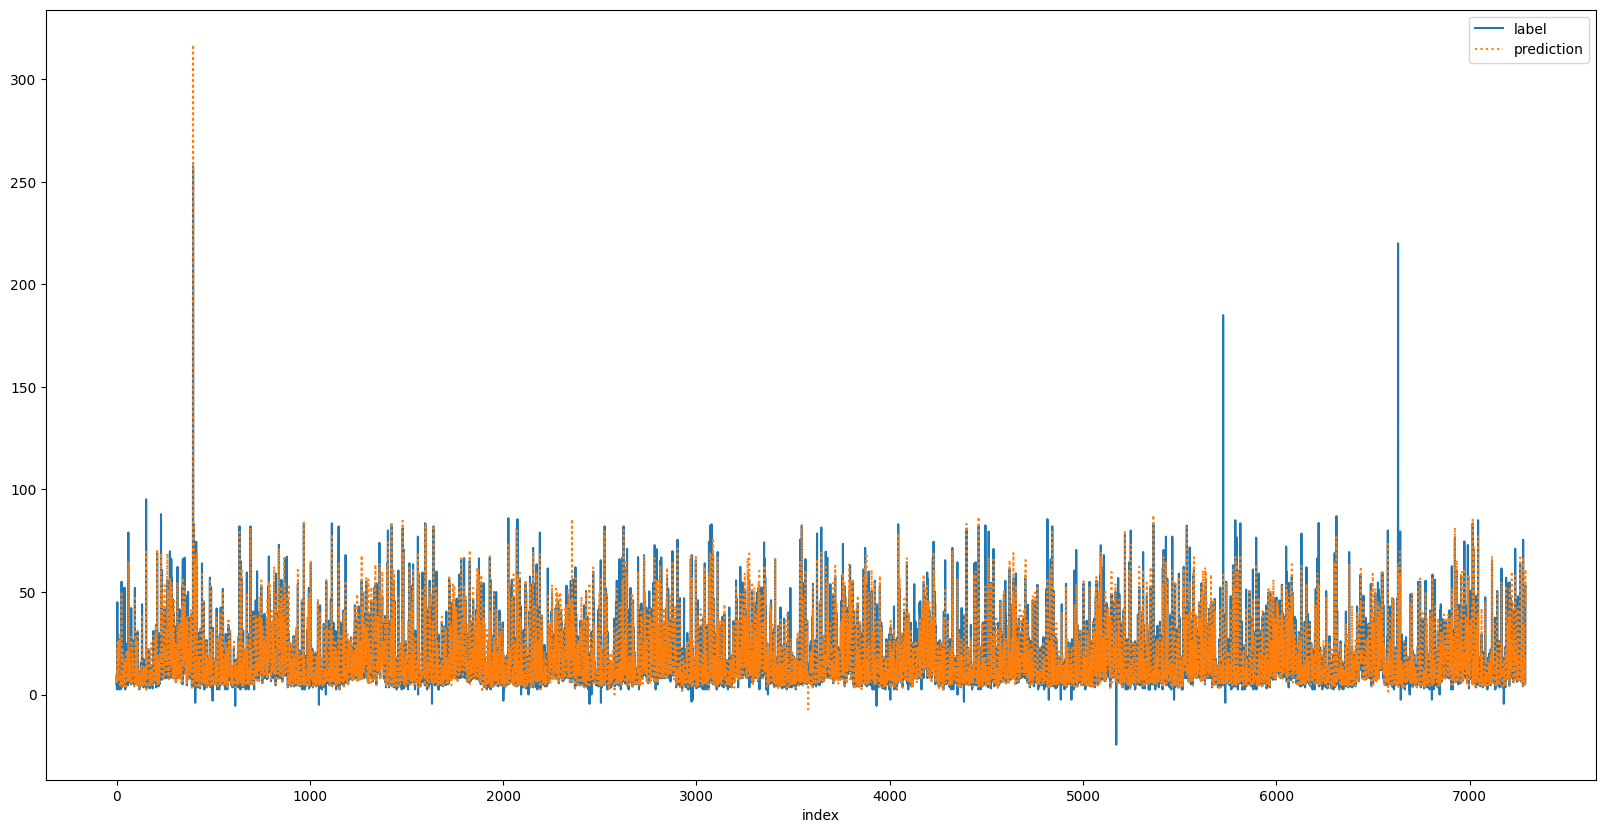

In [27]:
# predicted fare vs actual fare plots -- will this work for databricks / synapse / local ?
predictions_pdf = None
try:
    predictions_pdf = predictions.select(["label", "prediction"]).toPandas().reset_index()

    predictions_pdf.plot(
        x="index",
        y=["label", "prediction"],
        style=['-', ':'],
        figsize=(20, 10),
    )
except NameError:
    print("Inconsistent NumPy version detected. Skipping plotting.")

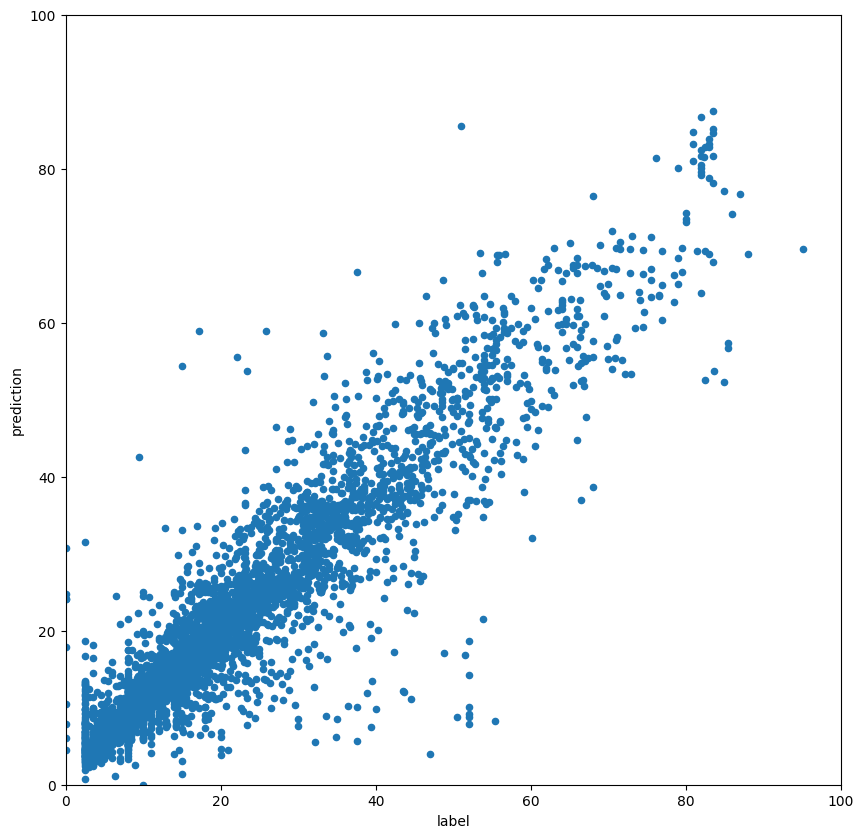

In [28]:
if predictions_pdf is not None:
    predictions_pdf.plot.scatter(
        x="label",
        y="prediction",
        xlim=(0, 100),
        ylim=(0, 100),
        figsize=(10, 10),
    )

## Cleanup

In [29]:
# TODO: Unregister, delete cached files or do any other cleanups.

In [30]:
# Stop the spark session if it is a local session.
if is_jupyter():
    spark.stop()